Update and install libraries

In [1]:
!git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull && cd ..

!pip install -qr vision_transformer/vit_jax/requirements.txt
!pip install -q tfds-nightly
#!pip install -U optax

Cloning into 'vision_transformer'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 49 (delta 6), reused 18 (delta 4), pack-reused 0
Unpacking objects: 100% (49/49), 1.86 MiB | 5.45 MiB/s, done.
Already up to date.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.5/390.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.6/225.6 MB 3.1 MB/

In [1]:
!pip list | grep jax

jax                              0.3.25
jaxlib                           0.3.25


Import libraries


In [2]:
!pip install jax==0.3.25 jaxlib==0.3.25 flax==0.6.2 orbax-checkpoint==0.1.1

!pip list | grep jax

  Using cached jax-0.3.25-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 6.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of chex to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: jax
    Found existing installation: jax 0.4.13
    Uninstalling jax-0.4.13:
      Successfully uninstalled jax-0.4.13
  Attempting uninstall: chex
    Found existing installation: chex 0.1.7
    Uninstalling chex-0.1.7:
      Successfully uninstalled chex-0.1.7
  Attempting uninstall: flax
    Found existing installation: flax 0.6.11
    Uninstalling flax-0.6.11:
      Successfully uninstalled flax-0.6.11
  Attempting uninstall: orbax-checkpoint
    Found existing i

In [2]:
import jax, PIL, os, jax.tools.colab_tpu, flax, numpy as np, sys, cv2, shutil, zipfile, pandas as pd, tensorflow as tf, os, tensorflow_datasets as tfds, optax, tqdm, ml_collections
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')
%load_ext autoreload
%autoreload 2
from absl import logging
from matplotlib import pyplot as plt
from vit_jax import checkpoint, input_pipeline, utils, models, train
from vit_jax.configs import common as common_config, models as models_config
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount("/content/gdrive")
%env USE_TORCH=False

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
env: USE_TORCH=False


## Download dataset

In [5]:
!cp "/content/gdrive/MyDrive/PUC/TCC/Notebooks/preTreinados/kaggle.json" "."
!chmod 600 kaggle.json
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
with zipfile.ZipFile("/content/skin-cancer-mnist-ham10000.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
del zip_ref
!mv /content/HAM10000_images_part_1/*.jpg /content/HAM10000_images_part_2

100% 5.18G/5.20G [01:02<00:00, 203MB/s]
100% 5.20G/5.20G [01:02<00:00, 89.3MB/s]


In [5]:
datasetMetadata = pd.read_csv("/content/HAM10000_metadata.csv")
datasetMetadata = datasetMetadata.drop(columns=['dx_type','age','sex','localization']) # Non-utilized columns
datasetMetadata = datasetMetadata.rename(columns={"lesion_id": "lesionId",
                                                  "image_id": "imageId",
                                                  "dx": "cancerId"})
datasetMetadata['duplicate'] = datasetMetadata['lesionId']      # Creating a column to indicate if the lesion has more than one image

uniqueLesions = datasetMetadata.groupby('lesionId').count()     # Counts the number of lesions for each id
uniqueLesions = uniqueLesions[uniqueLesions['imageId'] == 1]    # Filter lesions which ones have unique id
uniqueLesions.reset_index(inplace = True)                       # Add default index column
uniqueLesions = uniqueLesions['lesionId'].values.tolist()       # Extracts the indexes into a list

datasetMetadata['duplicate'] = datasetMetadata['lesionId'].apply(lambda x: False if x in uniqueLesions else True) # Fill the rows indicating if the lesion has a duplicated image

del uniqueLesions
datasetMetadata = datasetMetadata[~((datasetMetadata['lesionId'].duplicated()) & (datasetMetadata['duplicate']))]
cancerType = {
    'akiec': 0, # 0.0 - 'Doenca de Bowens'
    'bcc': 1, # 1.0 - 'Carcinoma basocelular'
    'bkl': 2, # 2.0 - 'Keratose benigna'
    'df': 3, # 3.0 - 'Dermatofibroma'
    'vasc': 4, # 4.0 - 'Lesao vascular'
    'mel': 5, # 5.0 - 'Melanoma'
    'nv': 6  # 6.0 - 'Nevo melanocitico'
}
num_classes = len(cancerType)
#datasetMetadata['cancerId'] = datasetMetadata['cancerId'].map(cancerType) # Map each class into an integer

#imgs = []

parentDir = './classes'
subdirectories = ['akiec', 'bcc', 'bkl', 'df', 'vasc', 'mel', 'nv']

os.makedirs(parentDir, exist_ok=True)
for subdir in ['train', 'test']:
    os.makedirs(os.path.join(parentDir, subdir), exist_ok=True)
    subdirPath = os.path.join(parentDir, subdir)
    for subsubdir in subdirectories:
        os.makedirs(os.path.join(subdirPath, subsubdir), exist_ok=True)

x = datasetMetadata[['lesionId', 'imageId']]
y = datasetMetadata['cancerId']

X_train, X_test, y_train, y_test = train_test_split(x, y,test_size = 0.2, train_size = 0.8, stratify = y)

def sortImages(parentDir, x, y):
    for i in range(len(x)):
      """@TODO TEST"""
      imageId = x.iloc[i]['imageId']
      cancerId = y.iloc[i]
      destinationPath = ''
      if cancerId == 'akiec':
        destinationPath = os.path.join(parentDir, 'akiec/' + imageId + '.jpg')
      elif cancerId == 'bcc':
        destinationPath = os.path.join(parentDir, 'bcc/'   + imageId + '.jpg')
      elif cancerId == 'bkl':
        destinationPath = os.path.join(parentDir, 'bkl/'   + imageId + '.jpg')
      elif cancerId == 'df':
        destinationPath = os.path.join(parentDir, 'df/'    + imageId + '.jpg')
      elif cancerId == 'vasc':
        destinationPath = os.path.join(parentDir, 'vasc/'  + imageId + '.jpg')
      elif cancerId == 'mel':
        destinationPath = os.path.join(parentDir, 'mel/'   + imageId + '.jpg')
      elif cancerId == 'nv':
        destinationPath = os.path.join(parentDir, 'nv/'    + imageId + '.jpg')
      shutil.move(''.join(["/content/HAM10000_images_part_2/", imageId, '.jpg']), destinationPath)
#sortImages('./classes/train', X_train, y_train)
#sortImages('./classes/test', X_test, y_test)
del X_train, X_test, y_train, y_test, x, y,parentDir, subdirectories, subsubdir, subdirPath, datasetMetadata
    #img = cv2.imread(''.join(["/content/HAM10000_images_part_2/",row['imageId'], '.jpg']))
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = cv2.resize(img, (224,224))
    #imgs.append(img)

In [7]:
#XTrain,XTest,YTrain,YTest = train_test_split(imgs, datasetMetadata['cancerId'],test_size = 0.2, train_size = 0.8, stratify = datasetMetadata['cancerId'])

#XTrain = np.array(XTrain)
#YTrain = np.array(YTrain)
#XTest = np.array(XTest)
#YTest = np.array(YTest)

#XTrain = XTrain.reshape(-1, 224, 224, 3)
#XTest = XTest.reshape(-1, 224, 224, 3)

#ds_train = tf.data.Dataset.from_tensor_slices((XTrain, YTrain))
#ds_test = tf.data.Dataset.from_tensor_slices((XTest, YTest))

In [6]:
batch_size = 512
config = common_config.get_config()
config.batch = batch_size
config.pp = ml_collections.ConfigDict(
             {'train': 'train[:80%]',
              'test': 'test',
              'crop': 224})
#config.pp.crop = 224

ds_train = input_pipeline.get_data_from_directory(config=config, directory='./classes/train', mode='train')
ds_test = input_pipeline.get_data_from_directory(config=config, directory='./classes/test', mode='test')
del config

## Import VIT model

In [7]:
model_name = 'ViT-B_32'  #@param ["ViT-B_32", "Mixer-B_16"]

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

assert os.path.exists(f'{model_name}.npz')

In [10]:
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
  logging.set_verbosity(logging.INFO)
  print(jax.local_devices())
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

Connected to TPU.
[CpuDevice(id=0)]


model loading

In [8]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

classifier: token
hidden_size: 768
model_name: ViT-B_32
patches:
  size: !!python/tuple
  - 32
  - 32
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.0
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

Load and compile model

In [9]:
batch = next(iter(ds_train.as_numpy_iterator()))
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    batch['image'][0, :1],#next(iter(ds_train.map(lambda x, y: x).batch(1))),
    train=False,
), backend='cpu')()

In [10]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

### Evaluate

In [11]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: DeviceArray (7,)
params_repl.cls: _ShardedDeviceArray (8, 7)


In [12]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

In [13]:
def get_accuracy(params_repl):
  good = total = 0
  steps = 2003 // batch_size#input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size #2003
  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    #x = np.expand_dims(x, axis=0)
    #print(x.shape)
    #x = np.repeat(x, 8, axis=0)
    #print(x.shape)
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [14]:
# Random performance without fine-tuning.
get_accuracy(params_repl)

 67%|██████▋   | 2/3 [00:36<00:18, 18.29s/it]


DeviceArray(0.02929688, dtype=float32)

### Fine-tune

In [15]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
total_steps = 100
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.03

In [3]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()
print(jax.local_devices())

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


In [16]:
# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
tx = optax.chain(
    optax.clip_by_global_norm(grad_norm_clip),
    optax.sgd(
        learning_rate=lr_fn,
        momentum=0.9,
        accumulator_dtype='bfloat16',
    ),
)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, tx=tx)
opt_state = tx.init(params)
opt_state_repl = flax.jax_utils.replicate(opt_state)

In [17]:
# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

100%|██████████| 100/100 [13:29<00:00,  8.10s/it]


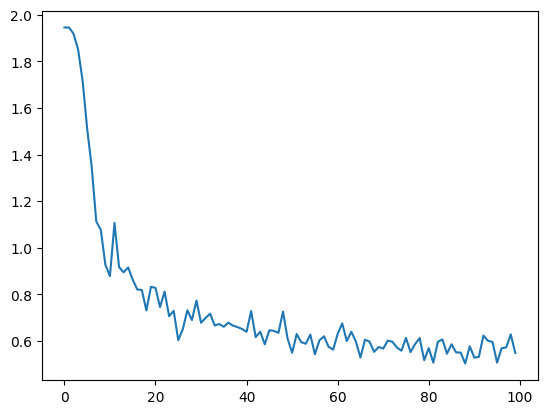

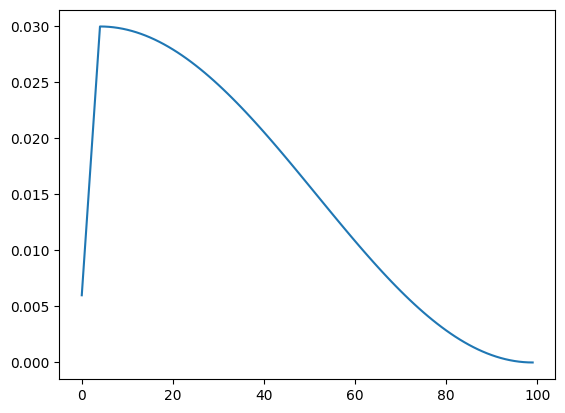

In [18]:
losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  params_repl, opt_state_repl, loss_repl, update_rng_repl = update_fn_repl(
      params_repl, opt_state_repl, batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

In [19]:
get_accuracy(params_repl)

 67%|██████▋   | 2/3 [00:21<00:10, 10.82s/it]


DeviceArray(0.7998047, dtype=float32)

### Inference

In [20]:
# Download a pre-trained model.

if model_name.startswith('Mixer'):
  # Download model trained on imagenet2012
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://mixer_models/imagenet1k/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.MlpMixer(num_classes=1000, **model_config)
else:
  # Download model pre-trained on imagenet21k and fine-tuned on imagenet2012.
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://vit_models/imagenet21k+imagenet2012/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.VisionTransformer(num_classes=1000, **model_config)

assert os.path.exists(f'{model_name}_imagenet2012.npz')

Copying gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1 files][336.9 MiB/336.9 MiB]   26.0 MiB/s                                   
Operation completed over 1 objects/336.9 MiB.                                    


In [21]:
# Load and convert pretrained checkpoint.
params = checkpoint.load(f'{model_name}_imagenet2012.npz')
params['pre_logits'] = {}  # Need to restore empty leaf for Flax.

In [22]:
# Get imagenet labels.
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

--2023-07-06 01:16:58--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2023-07-06 01:16:58 (76.0 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



--2023-07-06 01:16:58--  https://picsum.photos/384
Resolving picsum.photos (picsum.photos)... 104.26.5.30, 104.26.4.30, 172.67.74.163, ...
Connecting to picsum.photos (picsum.photos)|104.26.5.30|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://fastly.picsum.photos/id/948/384/384.jpg?hmac=t7KQiO_K36UOF-ohtiWJ3E-KKwCX2jck7rebQJnj2Uc [following]
--2023-07-06 01:16:59--  https://fastly.picsum.photos/id/948/384/384.jpg?hmac=t7KQiO_K36UOF-ohtiWJ3E-KKwCX2jck7rebQJnj2Uc
Resolving fastly.picsum.photos (fastly.picsum.photos)... 151.101.1.91, 151.101.65.91, 151.101.129.91, ...
Connecting to fastly.picsum.photos (fastly.picsum.photos)|151.101.1.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33198 (32K) [image/jpeg]
Saving to: ‘picsum.jpg’

picsum.jpg          100%[===================>]  32.42K  --.-KB/s    in 0.002s  

2023-07-06 01:16:59 (14.0 MB/s) - ‘picsum.jpg’ saved [33198/33198]



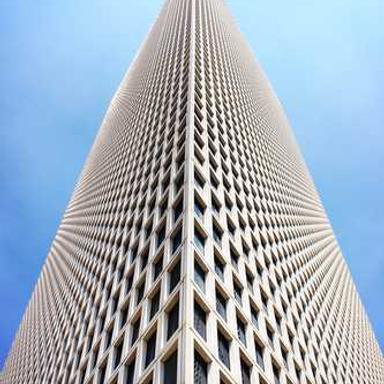

In [23]:
# Get a random picture with the correct dimensions.
resolution = 224 if model_name.startswith('Mixer') else 384
!wget https://picsum.photos/$resolution -O picsum.jpg
img = PIL.Image.open('picsum.jpg')
img

In [24]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = model.apply(dict(params=params), (np.array(img) / 128 - 1)[None, ...], train=False)

In [25]:
preds = np.array(jax.nn.softmax(logits))
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.11450 : planetarium
0.06905 : traffic_light, traffic_signal, stoplight
0.05329 : coil, spiral, volute, whorl, helix
0.05067 : dome
0.04960 : vault
0.04797 : honeycomb
0.04038 : mosque
0.02552 : loudspeaker, speaker, speaker_unit, loudspeaker_system, speaker_system
0.02516 : street_sign
0.01704 : palace
